# Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
import string, re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
pd.set_option('display.max_columns', 1000)

In [47]:
data = pd.read_csv('tweets_2.csv')

# Checking out Data

In [48]:
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [143]:
data[data.target == 1]['keyword'].value_counts()

thunderstorm    77
collision       57
derailment      54
sinkhole        52
body%20bag      36
                ..
crushed          1
deluge           1
arsonist         1
derail           1
bioterrorism     1
Name: keyword, Length: 201, dtype: int64

In [50]:
locations = pd.DataFrame(data.location.value_counts())

In [51]:
locations.reset_index(inplace = True)
locations.rename(columns = ({'index': 'country', 'location' : 'count'}), inplace = True)

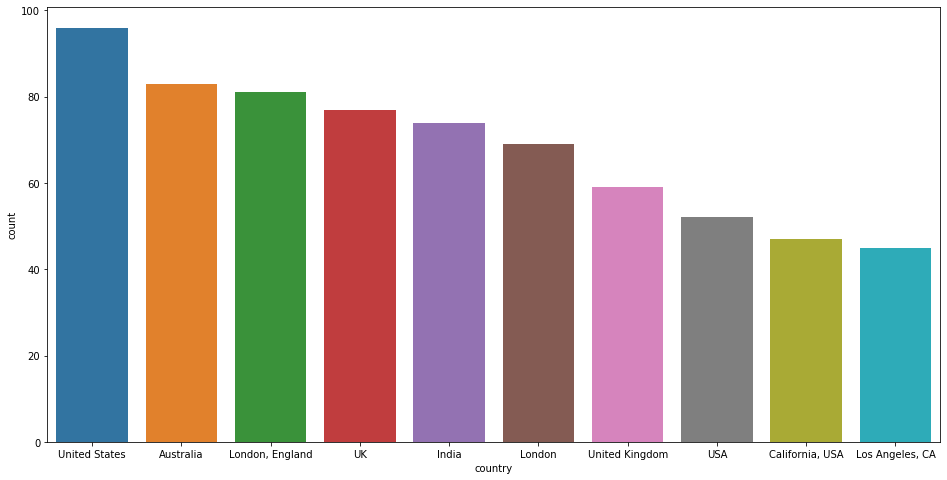

In [52]:
top10 = locations.head(10)
fig, ax = plt.subplots( figsize = (16,8))
sns.barplot('country', 'count', data = top10 )

In [53]:
locations.replace(to_replace = (['United States', 'US','California, USA', 'Los Angeles, CA']),value = 'USA', inplace = True)

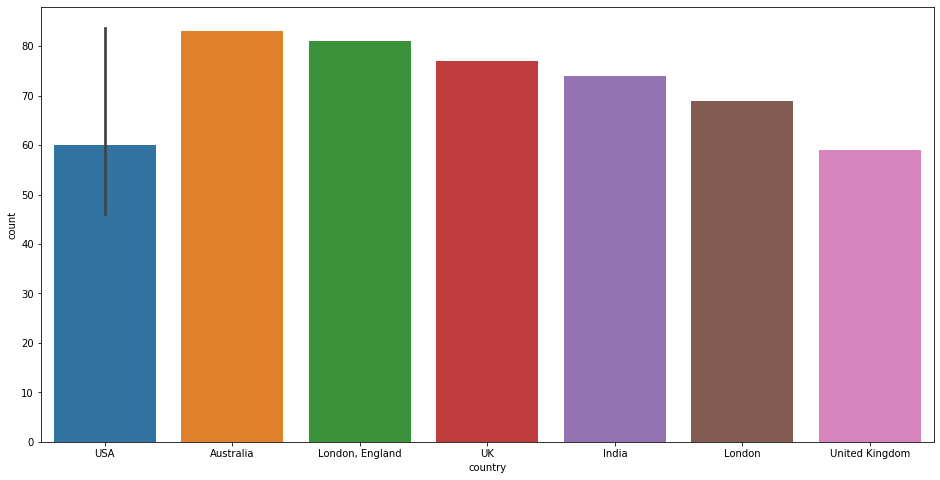

In [54]:
top10 = locations.head(10)
fig, ax = plt.subplots( figsize = (16,8))
sns.barplot('country', 'count', data = top10 )

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
id          11370 non-null int64
keyword     11370 non-null object
location    7952 non-null object
text        11370 non-null object
target      11370 non-null int64
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [56]:
# Checking for class imbalance
data.target.value_counts()

0    9256
1    2114
Name: target, dtype: int64

In [57]:
# dropping not used columns


# Tokenizing Words

In [58]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+')

data.text = data.text.apply(lambda x: tokenizer.tokenize(x))

In [59]:
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"[Communal, violence, in, Bhainsa, Telangana, S...",1
1,1,ablaze,NaN,"[Telangana, Section, 144, has, been, imposed, ...",1
2,2,ablaze,New York City,"[Arsonist, sets, cars, ablaze, at, dealership,...",1
3,3,ablaze,"Morgantown, WV","[Arsonist, sets, cars, ablaze, at, dealership,...",1
4,4,ablaze,NaN,"[Lord, Jesus, your, love, brings, freedom, and...",0


# Lemmitization

In [60]:
lemmatizer = WordNetLemmatizer() 

def lemm_text(words):
    lem = []
    for word in words:
        lem.append(lemmatizer.lemmatize(word))
    return lem  

In [61]:
data.text = data.text.apply(lambda x: lemm_text(x))

In [62]:
# Reformat to singular strings per observation
data.text = data.text.apply(lambda x: ','.join(x))
data.text = data.text.apply(lambda x: x.replace(',',' '))

# Vectorizing

In [63]:
token = RegexpTokenizer([\w]+ fire)
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(data.text)


SyntaxError: unexpected character after line continuation character (<ipython-input-63-7e1de9e1a022>, line 1)

In [ ]:
df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())
df.head()

In [ ]:
# renaming columns to avoid join overlap
data.columns = ['text_original','target_classification']

In [64]:
data2 = data.join(df, how='outer')

NameError: name 'df' is not defined

In [65]:
data2.head()

NameError: name 'data2' is not defined

### Creating Barplots for the frequency of each word in the target and non target tweets

In [66]:
data2_disaster = data[data.target_classification == 1]['text_original']
data2_notdisaster = data[data.target_classification == 0]['text_original']


AttributeError: 'DataFrame' object has no attribute 'target_classification'

In [67]:
data2_disaster.filter(regex= '\w+ fire')

NameError: name 'data2_disaster' is not defined

In [68]:
data2_disaster.head()

NameError: name 'data2_disaster' is not defined

In [69]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            'said', 'one', 'com', 'http', '-', '–', '—', 'co', 'wa', 'ha', '1', 'amp']
sw_set = set(sw_list)

In [70]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

In [71]:
pros_dis = list(map(process_article, data2_disaster))
pros_not_dis = list(map(process_article, data2_notdisaster))


NameError: name 'data2_disaster' is not defined

In [72]:
flat_non_dis = [item for sublist in pros_not_dis for item in sublist]
flat_dis =  [item for sublist in pros_dis for item in sublist]

NameError: name 'pros_not_dis' is not defined

In [73]:
non_dis_freq = FreqDist(flat_non_dis)
dis_freq = FreqDist(flat_dis)

NameError: name 'flat_non_dis' is not defined

In [74]:
non_dis_df = pd.DataFrame(non_dis_freq.most_common())
dis_df = pd.DataFrame(dis_freq.most_common())

NameError: name 'non_dis_freq' is not defined

In [75]:
dis_df = dis_df.rename(columns = {0: 'word', 1: 'count'})
non_dis_df = non_dis_df.rename(columns={0: 'word', 1: 'count'})

NameError: name 'dis_df' is not defined

In [76]:
top_15 = dis_df.head(15)
top_15non = non_dis_df.head(15)

NameError: name 'dis_df' is not defined

NameError: name 'top_15non' is not defined

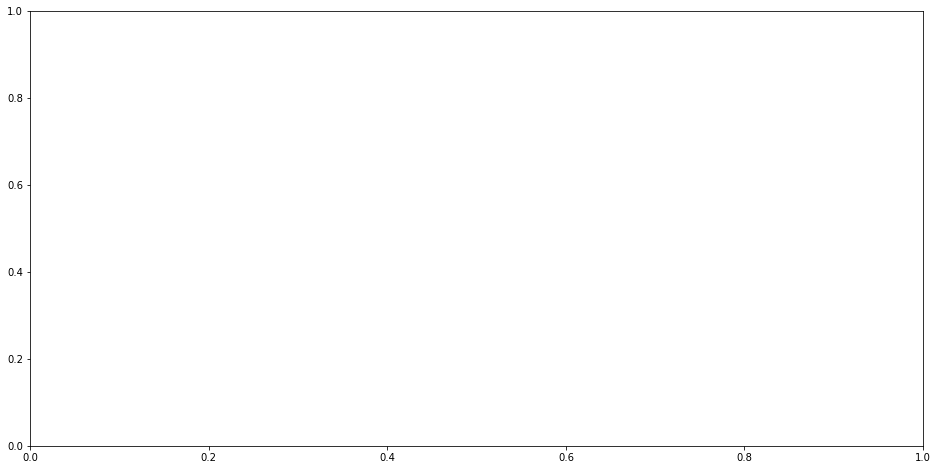

In [77]:
fig, ax = plt.subplots( figsize = (16,8))
ax1 = sns.barplot('word', 'count', data = top_15non)


In [ ]:
fig, ax = plt.subplots( figsize = (16,8))
ax1 = sns.barplot('word', 'count', data = top_15)


In [78]:
data.text_original.filter(regex = '\w+ fire')

AttributeError: 'DataFrame' object has no attribute 'text_original'

# Modelling with TDIDF

In [108]:
X = data.text
Y = data.target
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score

In [95]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X, Y, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer(ngram_range= (1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)



In [103]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [104]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [110]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = recall_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8769

F1 Score: 0.3341


In [93]:
from sklearn.naive_bayes import MultinomialNB

In [112]:
nb_classifier = MultinomialNB()

In [129]:
nb_classifier.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds = nb_classifier.predict(tfidf_data_test_lem)


In [130]:
f1_score(y_test_lem, nb_test_preds)

0.22365591397849463

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


confusion_matrix(y_test_lem, nb_test_preds)

array([[1861,    0],
       [ 361,   52]])

In [120]:
confusion_matrix(y_test_lem, rf_test_preds_lem)

array([[1856,    5],
       [ 275,  138]])

In [125]:
y_test_lem.value_counts()

0    1861
1     413
Name: target, dtype: int64

In [128]:
rf_test_preds_lem.sum()

143